### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

# Show all of the data in a dataframe
pd.set_option('display.max_columns', None)

### Load Data

In [2]:
# Training Set
application_train = pd.read_csv('data/application_train.csv')
print("Loaded Training Set: {0} rows".format(application_train.shape[0]))

columns = pd.read_csv('data/HomeCredit_columns_description.csv')

Loaded Training Set: 307511 rows


In [3]:
non_numeric_features = []    # non-numeric features for one-hot encoding
numeric_features = []        # numeric features (for feature scaling)
string_to_bool_features = [] # boolean features (that need conversion from string to binary)
log_transform_features = []  # skewed features that need log transformation

### Inspect Data

#### Application Data

In [4]:
display(application_train.head(n=10))

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Utility Functions

In [5]:
# Visualize the contents of a non-numeric column

def explore_non_numeric(field, showDetails=True):

    # Inspired By: 
    # https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array

    unique, counts = np.unique(field, return_counts=True)
    total_records = np.size(field)

    if (showDetails): 
        i = 0
        while i < np.size(unique): 
            percentage = (counts[i] / total_records) * 100
            print("Value: {0} Count: {1} Percentage: {2}".format(unique[i], counts[i], percentage))
            i += 1

    # Example code from: https://matplotlib.org/examples/pie_and_polar_charts/pie_demo_features.html
    fig1, ax1 = plt.subplots()
    ax1.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [6]:
# Visualize the contents of a numeric column

def explore_numeric(field, showUnique=False, graphType="dist", bins=20, showMeanLines=True):     
    mean = np.mean(field)
    avg = np.average(field)
    
    # Take a look at the range
    print("Max: {0} Min: {1} Mean: {2} Avg: {3} Std: {4}".format(
    np.max(field),
    np.min(field),
    mean,
    avg,
    np.std(field)))

    # Unique Values
    # print("Values: {0}".format(application_train['CNT_CHILDREN'].unique()))

    if (showUnique): 
    
        unique, counts = np.unique(application_train['CNT_CHILDREN'], return_counts=True)
        total_records = np.size(application_train['CNT_CHILDREN'])

        i = 0
        while i < np.size(unique): 
            percentage = (counts[i] / total_records) * 100
            print("Value: {0} Count: {1} Percentage: {2}".format(unique[i], counts[i], percentage))
            i += 1

    # Examine distribution
    plt.figure(figsize=(15,10))
    plt.title("Distribution Graph")
    if (showMeanLines):
        plt.axvline(avg, color="red")    # Plot the average
        plt.axvline(mean, color="green") # Plot the mean
    
    if (graphType == "hist"): 
        sns.distplot(field,bins=bins)
    else: 
        sns.distplot(field)

#### TARGET

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

Value: 0 Count: 282686 Percentage: 91.92711805431351
Value: 1 Count: 24825 Percentage: 8.072881945686495


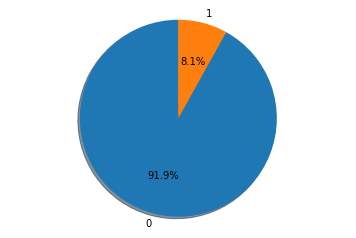

In [7]:
explore_non_numeric(application_train['TARGET'])

#### CODE_GENDER
Gender of the client

Value: F Count: 202448 Percentage: 65.83439291602576
Value: M Count: 105059 Percentage: 34.164306317497584
Value: XNA Count: 4 Percentage: 0.0013007664766463637


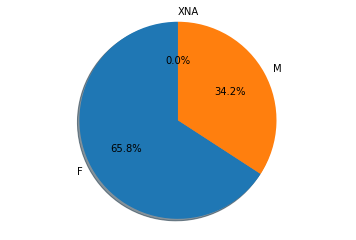

In [8]:
explore_non_numeric(application_train['CODE_GENDER'])

# Categorize it for one-hot encoding later
non_numeric_features.append('CODE_GENDER')

#### FLAG_OWN_CAR

Flag if the client owns a car

Value: N Count: 202924 Percentage: 65.98918412674668
Value: Y Count: 104587 Percentage: 34.010815873253314


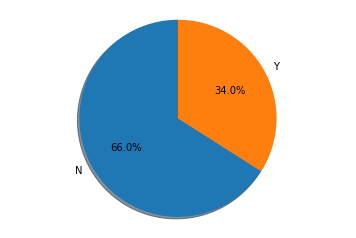

In [9]:
explore_non_numeric(application_train['FLAG_OWN_CAR'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

Value: 0 Count: 202924 Percentage: 65.98918412674668
Value: 1 Count: 104587 Percentage: 34.010815873253314


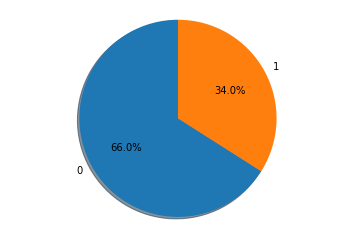

In [10]:
lb = LabelBinarizer()
bool_own_car = lb.fit_transform(application_train['FLAG_OWN_CAR'])

explore_non_numeric(bool_own_car)

string_to_bool_features.append("FLAG_OWN_CAR")

#### FLAG_OWN_REALTY

Flag if client owns a house or flat

Value: N Count: 94199 Percentage: 30.632725333402703
Value: Y Count: 213312 Percentage: 69.3672746665973


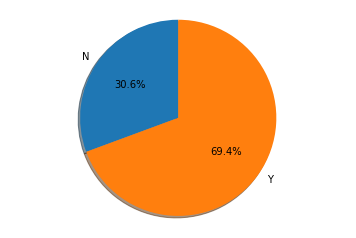

In [11]:
explore_non_numeric(application_train['FLAG_OWN_REALTY'])

# Categorize it for one-hot encoding later
non_numeric_features.append('FLAG_OWN_REALTY')

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

Value: 0 Count: 94199 Percentage: 30.632725333402703
Value: 1 Count: 213312 Percentage: 69.3672746665973


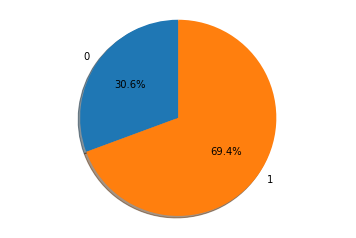

In [12]:
lb = LabelBinarizer()
bool_own_realty = lb.fit_transform(application_train['FLAG_OWN_REALTY'])

explore_non_numeric(bool_own_realty)

string_to_bool_features.append('FLAG_OWN_REALTY')

### CNT_CHILDREN
Number of children the client has

Max: 19 Min: 0 Mean: 0.4170517477423572 Avg: 0.4170517477423572 Std: 0.7221202102975595


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


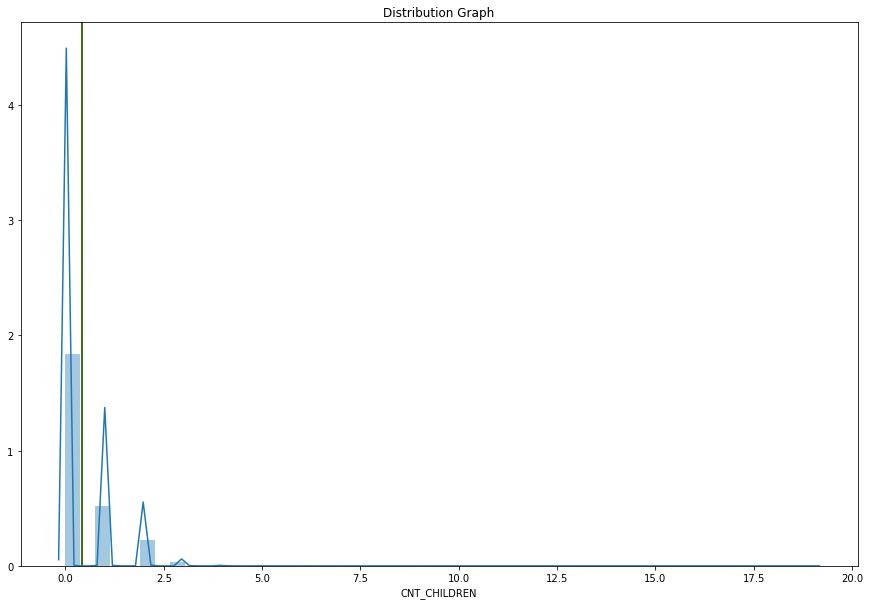

In [13]:
explore_numeric(application_train['CNT_CHILDREN'])   

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. 

Max: 2.995732273553991 Min: 0.0 Mean: 0.25311615347965405 Avg: 0.25311615347965405 Std: 0.40593657676776573


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


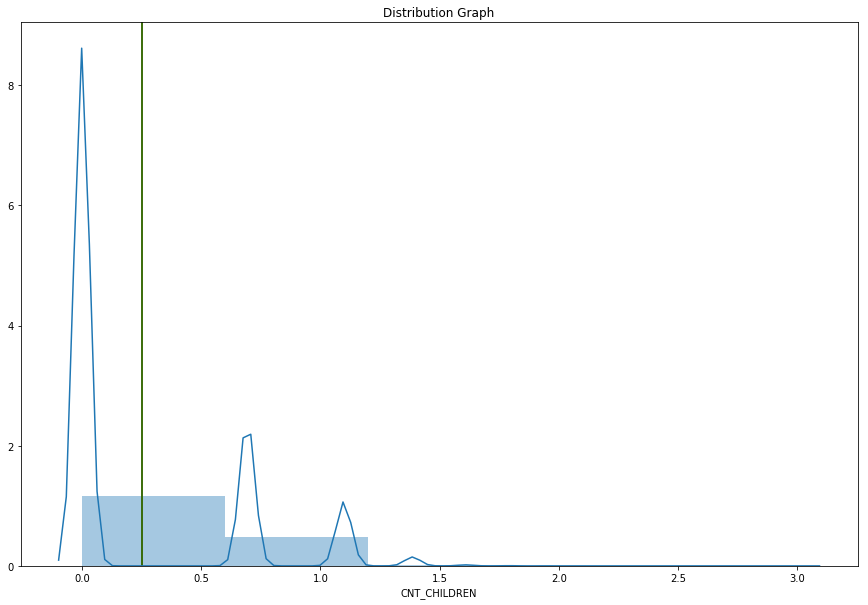

In [14]:
cnt_children = application_train['CNT_CHILDREN']
cnt_children_transformed = cnt_children.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(cnt_children_transformed, graphType="hist", bins=5)

log_transform_features.append('CNT_CHILDREN')



##### AMT_INCOME_TOTAL
Income of the client

Max: 117000000.0 Min: 25650.0 Mean: 168797.9192969845 Avg: 168797.9192969845 Std: 237122.7607262434


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


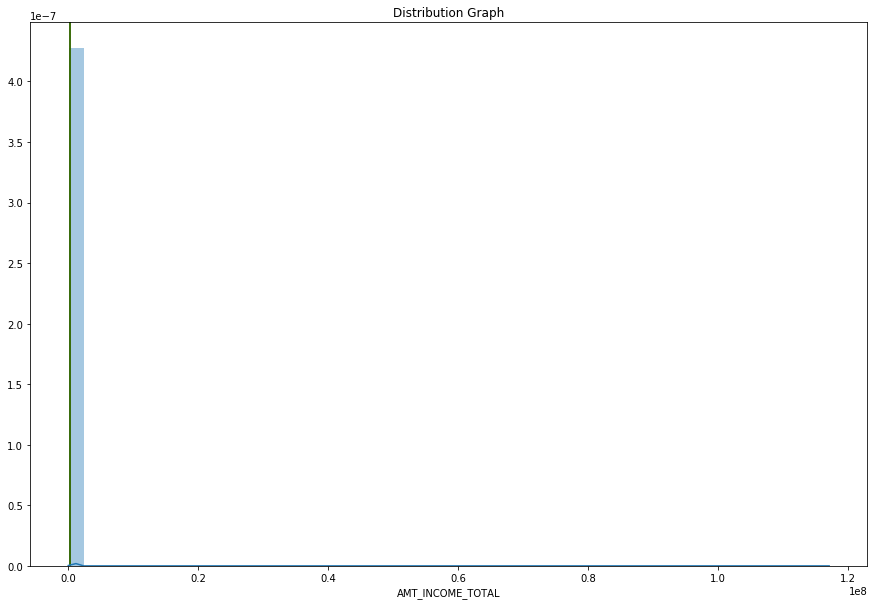

In [15]:
explore_numeric(application_train['AMT_INCOME_TOTAL'])

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

Max: 18.57768450130904 Min: 10.152337836193743 Mean: 11.909245341906919 Avg: 11.909245341906919 Std: 0.4889056656307125


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


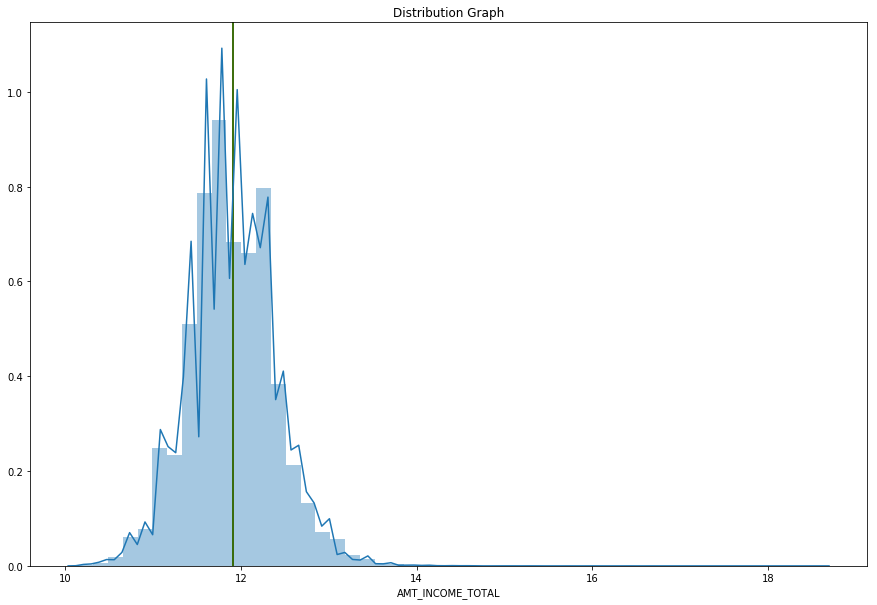

In [16]:
income_total = application_train['AMT_INCOME_TOTAL']
income_total_transformed = income_total.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(income_total_transformed)

log_transform_features.append('AMT_INCOME_TOTAL')

#### AMT_CREDIT
Credit amount of the loan

Max: 4050000.0 Min: 45000.0 Mean: 599025.9997057016 Avg: 599025.9997057016 Std: 402490.1225621855


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


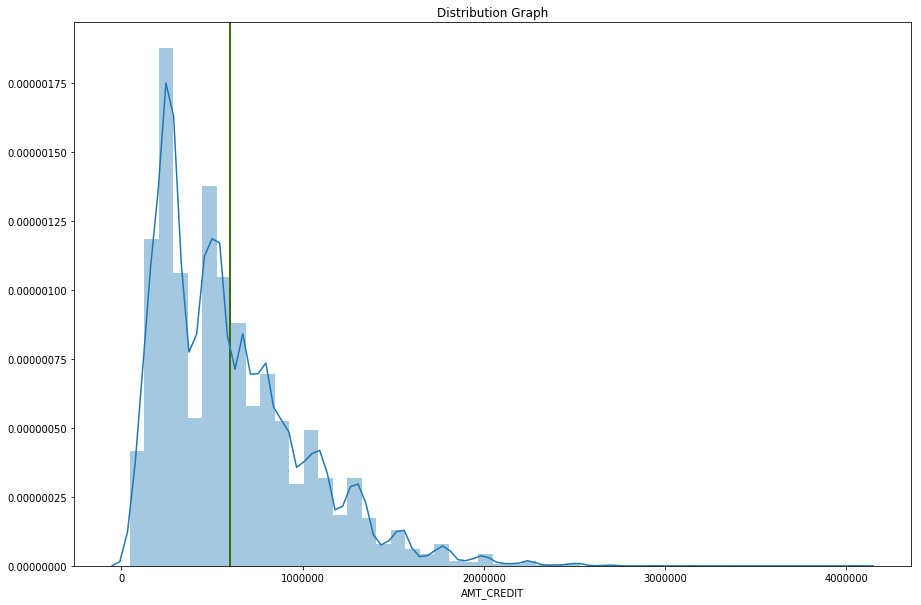

In [17]:
explore_numeric(application_train['AMT_CREDIT'])

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 15.214227685996272 Min: 10.714439990727769 Mean: 13.070108059483369 Avg: 13.070108059483369 Std: 0.715192195840206


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


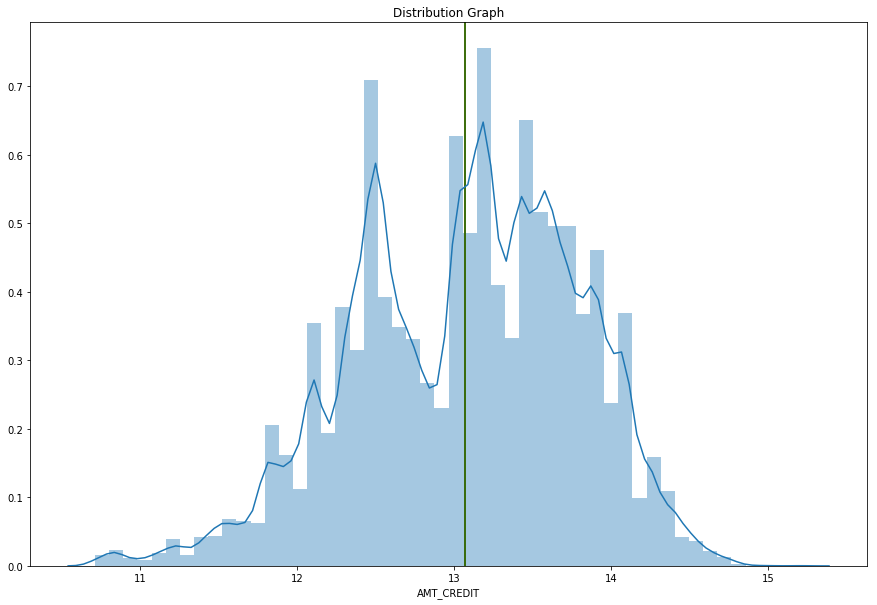

In [18]:
credit_total = application_train['AMT_CREDIT']
credit_total_transformed = credit_total.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(credit_total_transformed)

log_transform_features.append('AMT_CREDIT')

#### AMT_ANNUITY
Loan annuity

Max: 258025.5 Min: 0.0 Mean: 27107.516051458322 Avg: 27107.516051458322 Std: 14494.420189549066


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


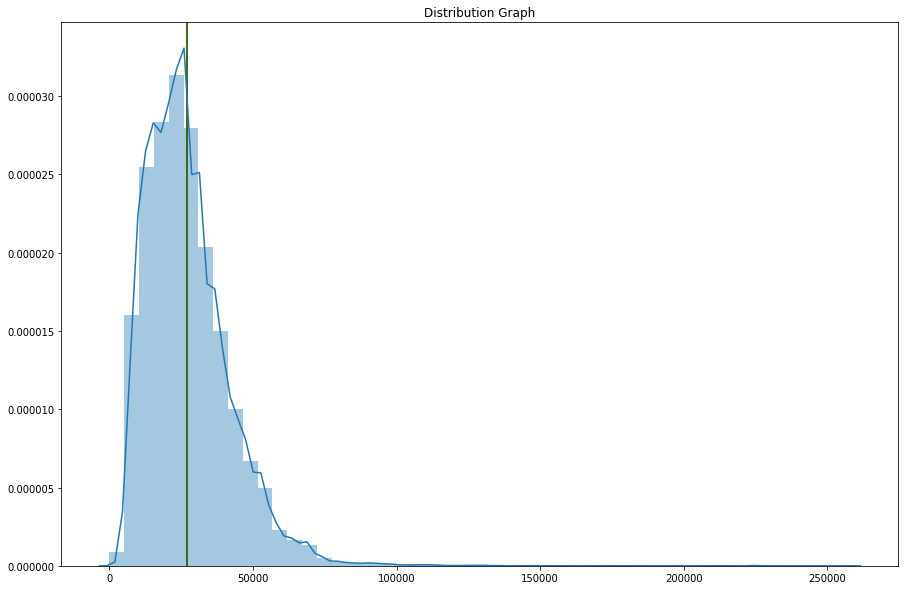

In [19]:
# Convert Non-Numerics
amt_annuity = np.nan_to_num(application_train['AMT_ANNUITY'], copy=True)
explore_numeric(amt_annuity)

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 12.460817571807413 Min: 0.0 Mean: 10.067281762604763 Avg: 10.067281762604763 Std: 0.5494814442293304


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


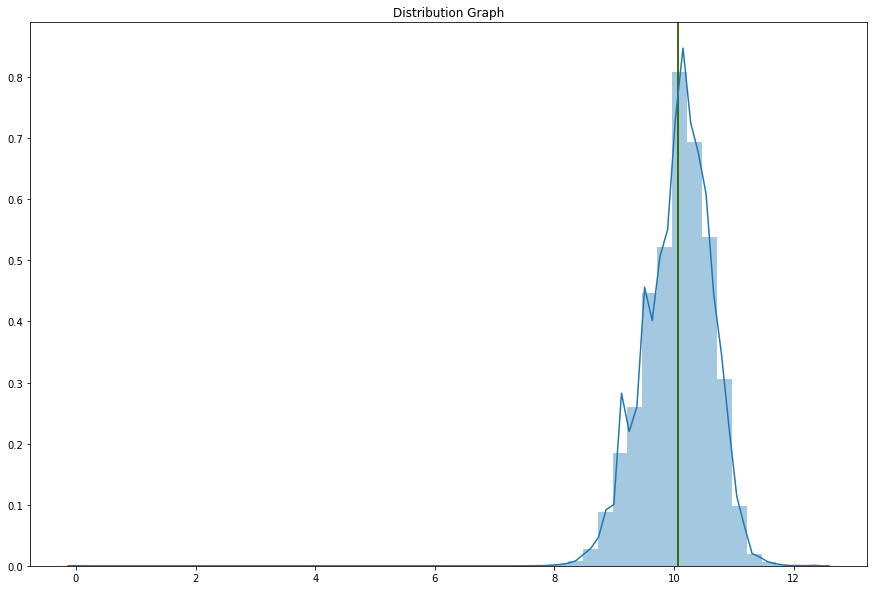

In [20]:
annuity = application_train['AMT_ANNUITY']
annuity_transformed = annuity.apply(lambda x: np.log(x + 1))
annuity_transformed_numeric = np.nan_to_num(annuity_transformed, copy=True)

#visualize the new distribution
explore_numeric(annuity_transformed_numeric)

log_transform_features.append('AMT_ANNUITY')

#### AMT_GOODS_PRICE
For consumer loans it is the price of the goods for which the loan is given

Max: 4050000.0 Min: 0.0 Mean: 537909.4796511345 Avg: 537909.4796511345 Std: 369633.15163863753


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


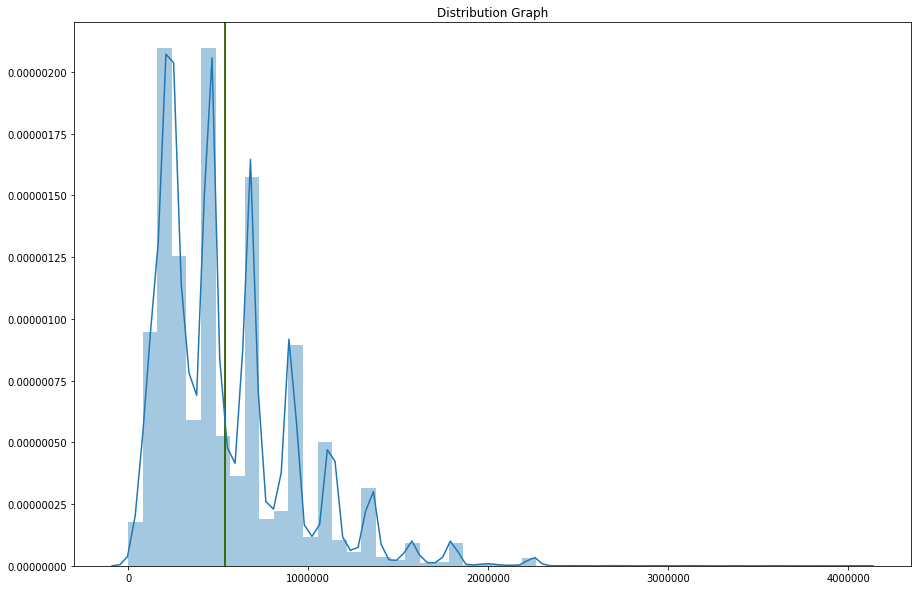

In [21]:
# Convert Non-Numerics
amt_goods_price = np.nan_to_num(application_train['AMT_GOODS_PRICE'], copy=True)
explore_numeric(amt_goods_price)

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 15.214227685996272 Min: 0.0 Mean: 12.948770745519909 Avg: 12.948770745519909 Std: 0.8143825559555455


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


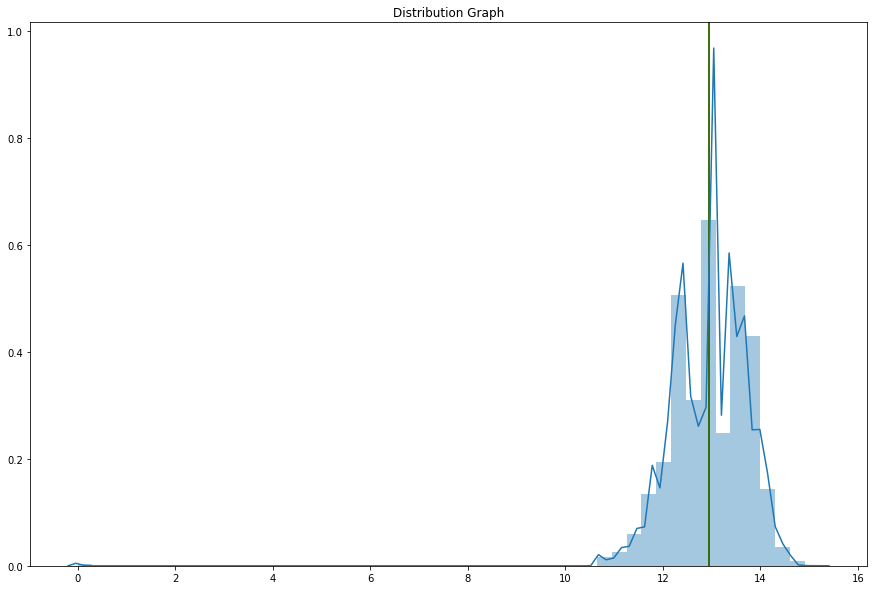

In [22]:
goods_price = application_train['AMT_GOODS_PRICE']
goods_price_transformed = goods_price.apply(lambda x: np.log(x + 1))
goods_price_transformed_numeric = np.nan_to_num(goods_price_transformed, copy=True)

#visualize the new distribution
explore_numeric(goods_price_transformed_numeric)

log_transform_features.append('AMT_GOODS_PRICE')

#### NAME_TYPE_SUITE
Who was accompanying client when he was applying for the loan

Value: Children Count: 3267 Percentage: 1.0624010198009177
Value: Family Count: 40149 Percentage: 13.056118317718715
Value: Group of people Count: 271 Percentage: 0.08812692879279115
Value: Other_A Count: 866 Percentage: 0.2816159421939378
Value: Other_B Count: 1770 Percentage: 0.575589165916016
Value: Spouse, partner Count: 11370 Percentage: 3.697428709867289
Value: Unaccompanied Count: 248526 Percentage: 80.81857234375356
Value: missing Count: 1292 Percentage: 0.42014757195677555


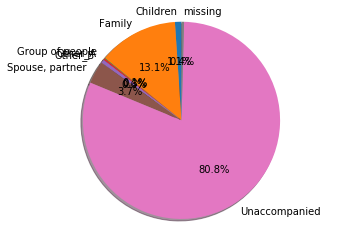

In [23]:
# Replace any nans with a string for easier encoding
# https://stackoverflow.com/questions/43066071/replace-numpy-nan-with-string-in-list-with-strings
name_type_suite = ['missing' if x is np.nan else x for x in application_train['NAME_TYPE_SUITE']]

explore_non_numeric(name_type_suite)

# Replace original data with modified data
application_train['NAME_TYPE_SUITE_NORMALIZED'] = name_type_suite
result = application_train.drop('NAME_TYPE_SUITE',axis=1)

# One-Hot Encode This Later
non_numeric_features.append('NAME_TYPE_SUITE_NORMALIZED')

#### NAME_INCOME_TYPE
Clients income type (businessman, working, maternity leave)

In [ ]:
explore_non_numeric(application_train['NAME_INCOME_TYPE'])

# One-Hot Encode This Later
non_numeric_features.append("NAME_INCOME_TYPE")

#### NAME_EDUCATION_TYPE
Level of highest education the client achieved

In [ ]:
explore_non_numeric(application_train['NAME_EDUCATION_TYPE'])

# One-Hot Encode This Later
non_numeric_features.append("NAME_EDUCATION_TYPE")

#### NAME_FAMILY_STATUS
Family status of the client

In [ ]:
explore_non_numeric(application_train['NAME_FAMILY_STATUS'])

# One-Hot Encode This Later
non_numeric_features.append("NAME_FAMILY_STATUS")

#### NAME_HOUSING_TYPE
What is the housing situation of the client (renting, living with parents, ...)

In [ ]:
explore_non_numeric(application_train['NAME_HOUSING_TYPE'])

# One-Hot Encode This Later
non_numeric_features.append("NAME_HOUSING_TYPE")

#### REGION_POPULATION_RELATIVE
Normalized population of region where client lives (higher number means the client lives in more populated region)

In [ ]:
explore_numeric(application_train['REGION_POPULATION_RELATIVE'])

# Add to our list of numeric features so that we scale the values appropriately later
numeric_features.append('REGION_POPULATION_RELATIVE')

#### DAYS_BIRTH
Client's age in days, [subtracted from] at the time of application

In [ ]:
explore_numeric(application_train['DAYS_BIRTH'])

# Add to our list of numeric features so that we scale the values appropriately later
numeric_features.append('DAYS_BIRTH')

#### DAYS_EMPLOYED
How many days before the application the person started current employment

In [ ]:
explore_numeric(application_train['DAYS_EMPLOYED'])

#### Preprocessing: 
There's a large body of outliers that indicate that someone has worked ~100 years.  This is clearly wrong.  Also, I don't expect this field to be normally distributed (I think you'd see a decreasing number of people employed in the same role over time and a body of people with no job or no work history), so doing a log transformation seems inappropriate.


In [ ]:
days_employed = application_train['DAYS_EMPLOYED']

# A bunch of records indicate that the person has worked for ~100 years.
# We'll need to replace those
days_employed = days_employed.replace({365243: 0})

#visualize the new distribution
explore_numeric(days_employed)

# Swap the normalized data with the original field
application_train['DAYS_EMPLOYED_TRANSFORMED'] = days_employed
result = application_train.drop('DAYS_EMPLOYED',axis=1)

# Add to our list of numeric features so that we scale the values appropriately later
numeric_features.append('DAYS_EMPLOYED_TRANSFORMED')

#### DAYS_REGISTRATION
How many days before the application did client change his registration

In [ ]:
explore_numeric(application_train['DAYS_REGISTRATION'])
numeric_features.append('DAYS_REGISTRATION')

#### DAYS_ID_PUBLISH
How many days before the application did client change the identity document with which he applied for the loan

In [ ]:
days_id_publish = application_train['DAYS_ID_PUBLISH']
numeric_features.append('DAYS_ID_PUBLISH')

#### OWN_CAR_AGE
Age of client's car

In [ ]:
own_car_age = application_train['OWN_CAR_AGE']
own_car_age_numeric = np.nan_to_num(application_train['OWN_CAR_AGE'])
own_car_age_numeric = pd.DataFrame(data=own_car_age_numeric)
explore_numeric(own_car_age_numeric, showMeanLines=False)

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks more normally distributed, and I think the high representation of people with new or no cars is more reasonable.

In [ ]:
own_car_age_numeric_transformed = own_car_age_numeric.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(own_car_age_numeric_transformed, showMeanLines=False)

log_transform_features.append('OWN_CAR_AGE')

#### FLAG_MOBIL
Did client provide mobile phone (1=YES, 0=NO)

In [ ]:
explore_non_numeric(application_train['FLAG_MOBIL'])

NOTE: Given the fact that 99.999% of people have a cellphone, we can drop this feature.  It has no value in terms of differentiation.

#### FLAG_EMP_PHONE

Did client provide work phone (1=YES, 0=NO)

In [ ]:
explore_non_numeric(application_train['FLAG_EMP_PHONE'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

In [ ]:
lb = LabelBinarizer()
bool_emp_phone = lb.fit_transform(application_train['FLAG_EMP_PHONE'])

explore_non_numeric(bool_emp_phone)

string_to_bool_features.append('FLAG_EMP_PHONE')

#### FLAG_WORK_PHONE
Did client provide home phone (1=YES, 0=NO)

In [ ]:
explore_non_numeric(application_train['FLAG_WORK_PHONE'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

In [ ]:
lb = LabelBinarizer()
bool_work_phone = lb.fit_transform(application_train['FLAG_WORK_PHONE'])

explore_non_numeric(bool_work_phone)

string_to_bool_features.append('FLAG_WORK_PHONE')

#### FLAG_PHONE
Did client provide home phone (1=YES, 0=NO)

In [ ]:
explore_non_numeric(application_train['FLAG_PHONE'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

In [ ]:
lb = LabelBinarizer()
bool_phone = lb.fit_transform(application_train['FLAG_PHONE'])

explore_non_numeric(bool_phone)

string_to_bool_features.append('FLAG_PHONE')

#### FLAG_EMAIL
Did client provide email (1=YES, 0=NO)

In [ ]:
explore_non_numeric(application_train['FLAG_EMAIL'])

### Preprocessing 
This is a Y/N string field.  We'll re-encode it as a bool for easier analysis later

In [ ]:
lb = LabelBinarizer()
bool_email = lb.fit_transform(application_train['FLAG_EMAIL'])

explore_non_numeric(bool_email)

string_to_bool_features.append('FLAG_EMAIL')

#### OCCUPATION_TYPE
Family status of the client

In [ ]:
occupation_type = application_train['OCCUPATION_TYPE']
occupation_type = occupation_type.replace(np.nan, "Missing")

explore_non_numeric(occupation_type)

# Swap the normalized data with the original field
application_train['OCCUPATION_TYPE_NORMALIZED'] = occupation_type
result = application_train.drop('OCCUPATION_TYPE',axis=1)

#Track this for one-hot encoding later
non_numeric_features.append("OCCUPATION_TYPE");

#### CNT_FAM_MEMBERS
How many family members does client have

In [ ]:
cnt_fam_members_numeric = np.nan_to_num(application_train['CNT_FAM_MEMBERS'])
explore_numeric(cnt_fam_members_numeric)

#### REGION_RATING_CLIENT
Our rating of the region where client lives (1,2,3)

In [ ]:
explore_numeric(application_train['REGION_RATING_CLIENT'], graphType="hist", bins=3)

#### REGION_RATING_CLIENT_W_CITY
Our rating of the region where client lives with taking city into account (1,2,3)

In [ ]:
explore_numeric(application_train['REGION_RATING_CLIENT_W_CITY'],graphType="hist",bins=3)

#### WEEKDAY_APPR_PROCESS_START
On which day of the week did the client apply for the loan

In [ ]:
explore_non_numeric(application_train['WEEKDAY_APPR_PROCESS_START'])
non_numeric_features.append("WEEKDAY_APPR_PROCESS_START")

#### HOUR_APPR_PROCESS_START
Approximately at what hour did the client apply for the loan

In [ ]:
explore_numeric(application_train['HOUR_APPR_PROCESS_START'],graphType="hist",bins=24)

#### REG_REGION_NOT_LIVE_REGION
Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)

In [ ]:
explore_non_numeric(application_train['REG_REGION_NOT_LIVE_REGION'])

#### REG_REGION_NOT_WORK_REGION
Flag if client's permanent address does not match work address (1=different, 0=same, at region level)

In [ ]:
explore_non_numeric(application_train['REG_REGION_NOT_WORK_REGION'])

#### LIVE_REGION_NOT_WORK_REGION
Flag if client's contact address does not match work address (1=different, 0=same, at region level)

In [ ]:
explore_non_numeric(application_train['LIVE_REGION_NOT_WORK_REGION'])

#### REG_CITY_NOT_LIVE_CITY
Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)

In [ ]:
explore_non_numeric(application_train['REG_CITY_NOT_LIVE_CITY'])

#### REG_CITY_NOT_WORK_CITY
Flag if client's permanent address does not match work address (1=different, 0=same, at city level)

In [ ]:
explore_non_numeric(application_train['REG_CITY_NOT_WORK_CITY'])

#### LIVE_CITY_NOT_WORK_CITY
Flag if client's contact address does not match work address (1=different, 0=same, at city level)

In [ ]:
explore_non_numeric(application_train['LIVE_CITY_NOT_WORK_CITY'])

#### ORGANIZATION_TYPE
Type of organization where client works

In [ ]:
explore_non_numeric(application_train['ORGANIZATION_TYPE'])

# Keep track for one-hot encoding later
non_numeric_features.append("ORGANIZATION_TYPE")

#### EXT_SOURCE_1
Normalized score from external data source

In [ ]:
ext_source_1 = np.nan_to_num(application_train['EXT_SOURCE_1'])
explore_numeric(ext_source_1)

#### EXT_SOURCE_2
Normalized score from external data source

In [ ]:
ext_source_2 = np.nan_to_num(application_train['EXT_SOURCE_2'])
explore_numeric(ext_source_1)

#### EXT_SOURCE_3
Normalized score from external data source

In [ ]:
ext_source_3 = np.nan_to_num(application_train['EXT_SOURCE_3'])
explore_numeric(ext_source_3)

#### APARTMENTS_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
apartments_avg = np.nan_to_num(application_train['APARTMENTS_AVG'])
explore_numeric(apartments_avg)

#### BASEMENTAREA_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
basementarea_avg = np.nan_to_num(application_train['BASEMENTAREA_AVG'])
explore_numeric(basementarea_avg)

#### YEARS_BEGINEXPLUATATION_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
years_beginexpluatation_avg = np.nan_to_num(application_train['YEARS_BEGINEXPLUATATION_AVG'])
explore_numeric(years_beginexpluatation_avg)

#### YEARS_BUILD_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
years_build_avg = np.nan_to_num(application_train['YEARS_BUILD_AVG'])
explore_numeric(years_build_avg)

#### COMMONAREA_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
commonarea_avg = np.nan_to_num(application_train['COMMONAREA_AVG'])
explore_numeric(commonarea_avg)

#### ELEVATORS_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
elevators_avg = np.nan_to_num(application_train['ELEVATORS_AVG'])
explore_numeric(elevators_avg)

#### ENTRANCES_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
entrances_avg = np.nan_to_num(application_train['ENTRANCES_AVG'])
explore_numeric(entrances_avg)

#### FLOORSMAX_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
floorsmax_avg = np.nan_to_num(application_train['FLOORSMAX_AVG'])
explore_numeric(floorsmax_avg)

#### FLOORSMIN_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
floorsmin_avg = np.nan_to_num(application_train['FLOORSMIN_AVG'])
explore_numeric(floorsmin_avg)

#### LANDAREA_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
landarea_avg = np.nan_to_num(application_train['LANDAREA_AVG'])
explore_numeric(landarea_avg)

#### LIVINGAPARTMENTS_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
livingapartments_avg = np.nan_to_num(application_train['LIVINGAPARTMENTS_AVG'])
explore_numeric(livingapartments_avg)

#### LIVINGAREA_AVG
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [ ]:
livingarea_avg = np.nan_to_num(application_train['LIVINGAREA_AVG'])
explore_numeric(livingarea_avg)

### Note: It looks like these cells are well-normalized and usable as-is.  Skipping the remainder of the normalized housing stats.

#### OBS_30_CNT_SOCIAL_CIRCLE
How many observation of client's social surroundings with observable 30 DPD (days past due) default

In [ ]:
obs_30 = np.nan_to_num(application_train['OBS_30_CNT_SOCIAL_CIRCLE'])
explore_numeric(obs_30)

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

In [ ]:
obs_30 = pd.DataFrame(data=obs_30)
obs_30_transformed = obs_30.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(obs_30_transformed, showMeanLines=False)

log_transform_features.append('OBS_30_CNT_SOCIAL_CIRCLE')

#### DEF_30_CNT_SOCIAL_CIRCLE
How many observation of client's social surroundings defaulted on 30 DPD (days past due)

In [ ]:
def_30 = np.nan_to_num(application_train['DEF_30_CNT_SOCIAL_CIRCLE'])
explore_numeric(def_30)

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

In [ ]:
# We need it to be a DataFrame column
def_30 = pd.DataFrame(data=def_30)

# Select the column with the actual data
def_30 =  def_30[0]

# Apply a log transformation
def_30_transformed = def_30.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(def_30_transformed)

log_transform_features.append('DEF_30_CNT_SOCIAL_CIRCLE_TRANSFORMED')

#### OBS_60_CNT_SOCIAL_CIRCLE
How many observation of client's social surroundings with observable 30 DPD (days past due) default

In [ ]:
obs_60 = np.nan_to_num(application_train['OBS_60_CNT_SOCIAL_CIRCLE'])
explore_numeric(obs_60)

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

In [ ]:
# We need it to be a DataFrame column
obs_60 = pd.DataFrame(data=obs_60)

# Select the column in the DataFrame with the actual data
obs_60 = obs_60[0]

obs_60_transformed = obs_60.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(obs_60_transformed, showMeanLines=False)

log_transform_features.append('OBS_60_CNT_SOCIAL_CIRCLE_TRANSFORMED')

#### DEF_60_CNT_SOCIAL_CIRCLE
How many observation of client's social surroundings defaulted on 60 DPD (days past due)

In [ ]:
def_60 = np.nan_to_num(application_train['DEF_60_CNT_SOCIAL_CIRCLE'])
explore_numeric(def_60)

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

In [ ]:
# We need it to be a DataFrame column
def_60 = pd.DataFrame(data=def_60)

# Select the column in the DataFrame with the actual data
def_60 = def_60[0]

def_60_transformed = def_60.apply(lambda x: np.log(x + 1))

#visualize the new distribution
explore_numeric(def_60_transformed)

log_transform_features.append('DEF_60_CNT_SOCIAL_CIRCLE_TRANSFORMED')

#### DAYS_LAST_PHONE_CHANGE
How many days before application did client change phone

In [ ]:
days = np.nan_to_num(application_train['DAYS_LAST_PHONE_CHANGE'])
explore_numeric(days)

#### Preprocessing: 
This feature is highly skewed, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks much more like a normal distribution, with mean and average values near the peak.

In [ ]:
days = pd.DataFrame(data=days)

# Select the column in the DataFrame with the actual data
days = days[0]

# Negative numbers are undefined for log, so offset them into the positive range
min = np.min(days)
offset = 2 * abs(min)

days_transformed = days.apply(lambda x: np.log(x + offset + 1))

#visualize the new distribution
explore_numeric(np.nan_to_num(days_transformed), showMeanLines=False)

log_transform_features.append('DAYS_LAST_PHONE_CHANGE_TRANSFORMED')

#### FLAG_DOCUMENT_4 - 21
Did client provide document 4

In [ ]:
print("Document 2")
explore_non_numeric(application_train['FLAG_DOCUMENT_2'])

print("Document 3")
explore_non_numeric(application_train['FLAG_DOCUMENT_3'])

print("Document 4")
explore_non_numeric(application_train['FLAG_DOCUMENT_4'])

print("Document 5")
explore_non_numeric(application_train['FLAG_DOCUMENT_5'])

print("Document 6")
explore_non_numeric(application_train['FLAG_DOCUMENT_6'])

print("Document 7")
explore_non_numeric(application_train['FLAG_DOCUMENT_7'])

print("Document 8")
explore_non_numeric(application_train['FLAG_DOCUMENT_8'])

print("Document 9")
explore_non_numeric(application_train['FLAG_DOCUMENT_9'])

print("Document 10")
explore_non_numeric(application_train['FLAG_DOCUMENT_10'])

print("Document 11")
explore_non_numeric(application_train['FLAG_DOCUMENT_11'])

print("Document 12")
explore_non_numeric(application_train['FLAG_DOCUMENT_12'])

print("Document 13")
explore_non_numeric(application_train['FLAG_DOCUMENT_13'])

print("Document 14")
explore_non_numeric(application_train['FLAG_DOCUMENT_14'])

print("Document 15")
explore_non_numeric(application_train['FLAG_DOCUMENT_15'])

print("Document 16")
explore_non_numeric(application_train['FLAG_DOCUMENT_16'])

print("Document 17")
explore_non_numeric(application_train['FLAG_DOCUMENT_17'])

print("Document 18")
explore_non_numeric(application_train['FLAG_DOCUMENT_18'])

print("Document 19")
explore_non_numeric(application_train['FLAG_DOCUMENT_19'])

print("Document 20")
explore_non_numeric(application_train['FLAG_DOCUMENT_20'])

print("Document 21")
explore_non_numeric(application_train['FLAG_DOCUMENT_21'])

### OUTPUT

Output lists of fields that need transformation for consumption by the preprocessing script

In [ ]:
non_numeric_features = pd.DataFrame(data=non_numeric_features)
numeric_features = pd.DataFrame(data=numeric_features)
string_to_bool_features = pd.DataFrame(data=string_to_bool_features)
log_transform_features = pd.DataFrame(data=log_transform_features)

non_numeric_features.to_csv('data/tmp/non_numeric_features.csv')
numeric_features.to_csv('data/tmp/numeric_features.csv')
string_to_bool_features.to_csv('data/tmp/string_to_bool.csv')
log_transform_features.to_csv('data/tmp/log_transform.csv')
